In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
def f(x):
  return 3*x**2 - 4*x + 5

In [11]:
f(3.0)

20.0

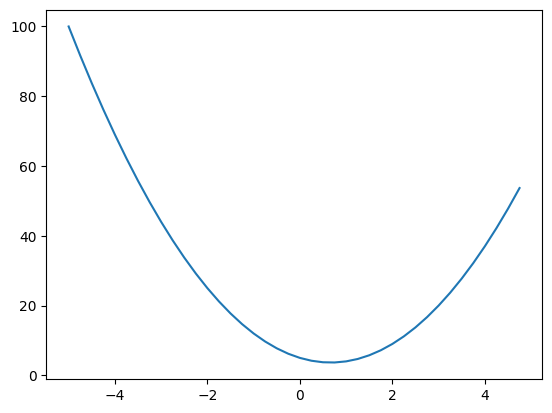

In [12]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [13]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [14]:
# more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [15]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [66]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad = 1.0 * out.grad
      other.grad = 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad = other.data * out.grad
      other.grad = self.data * out.grad
    out._backward = _backward

    return out

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad = (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [34]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label ='d'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [35]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is the eresult of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of nn2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

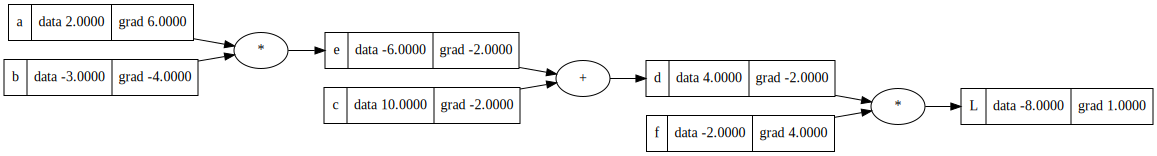

In [38]:
draw_dot(L)

In [37]:
a.grad = 6.0
b.grad = -4.0
c.grad = -2.0
d.grad = - 2.0
e.grad = -2.0
f.grad = 4.0
L.grad = 1.0

In [35]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)

-7.286496


In [8]:
def lol():

  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label ='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label ='d'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1) / h)

lol()

-3.9999999999995595


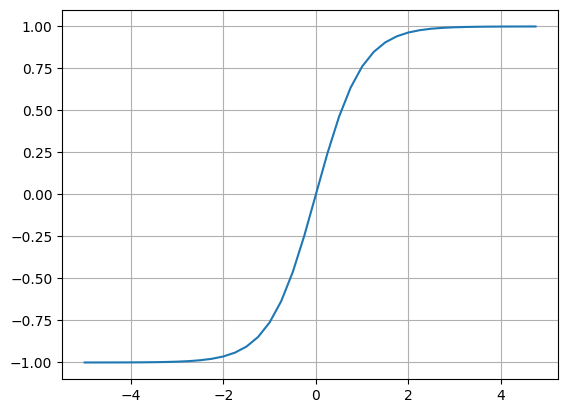

In [39]:
plt.plot(np.arange(-5, 5, 0.25), np.tanh(np.arange(-5, 5, 0.25))); plt.grid();

In [71]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + xx2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

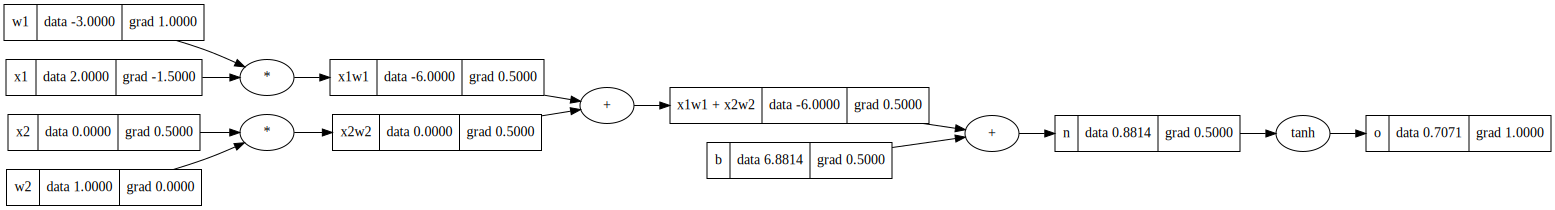

In [74]:
draw_dot(o)

In [73]:
o.backward()

In [59]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [62]:
o.grad = 1.0

In [50]:
o._backward()

In [51]:
n._backward()

In [53]:
b._backward()

In [54]:
x1w1x2w2._backward()

In [57]:
x1w1._backward()
x2w2._backward()

In [21]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [19]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [18]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [17]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [16]:
n.grad = 0.5

In [15]:
o.grad = 1.0

In [14]:
1 - o.data**2

0.4999999999999999

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2